In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tvt
from torch.utils.data.sampler import SubsetRandomSampler
import torch_directml
import matplotlib.pyplot as plt
import matplotlib.patches as ph
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import random
import os, time, gc
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import functools

# use directml to run codes on AMD GPU
dml = torch_directml.device()
dml

device(type='privateuseone', index=0)

In [37]:
class DataInfo:
    def __init__(self, dir='/home/parry/gitRepos/homeworks_ECE_60146/hw6_YuxinSun/coco', *, type='train2014', categories=None) -> None:
        self.dir  = dir
        self.type = type
        self.annFile = '%s/annotations/%s_%s.json'%(self.dir,'instances',self.type)
        # target images' information:
        self.ctgs = categories
        self.h = 256
        self.w = 256
        self.minArea = 4096

    def coco_json(self):
        return COCO(self.annFile)
    
yolo_interval = 8

class MyDataset(torch.utils.data.Dataset):
    xform = tvt.Compose([
        tvt.ToTensor(),
        # transform to range [-1, 1]:
        tvt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])
    yolo_interval = 8

    def __init__(self, data_info: DataInfo, *, save_dir="/home/parry/gitRepos/homeworks_ECE_60146/hw6_YuxinSun/resized", update=False):
        super().__init__()
        cocoGt = data_info.coco_json()
        self.dir = save_dir
        self.coco = cocoGt
        self.data = data_info
        self.catIds = cocoGt.getCatIds(catNms=data_info.ctgs)
        catType = self.data.ctgs
        self.catId_to_label = {cocoGt.getCatIds(catType[i])[0]: i  for i in range(len(catType))}
        self.label_to_cat = {i: catType[i] for i in range(len(catType))}

        self.imgIds = self.gen_data_id(update=update)

    def gen_data_id(self, *, update=False):
        cocoGt = self.coco
        catIds = self.catIds
        sets = [set(cocoGt.getImgIds(catIds=catId)) for catId in catIds]
        imgIds = functools.reduce(lambda a, b: a.union(b), sets)
        ids = []
        for imgId in imgIds:
            anns = cocoGt.loadAnns(cocoGt.getAnnIds(imgIds=imgId, iscrowd=False))
            for ann in anns:
                if ann['category_id'] in self.catIds \
                and ann['area'] >= self.data.minArea:
                    ids.append(imgId)
                    self.gen_resized_image(imgId, update)
                    # break inner for-loop
                    break
            # switch to next image
        return ids
    
    def resize(self, im, bbox):
        w_ori = im['width']
        h_ori = im['height']
        # xi, yi are in range [0,1]
        new_box = [bbox[0]/w_ori, bbox[1]/h_ori, \
                   bbox[2]/w_ori, bbox[3]/h_ori]
        return new_box

    def gen_resized_image(self, imgId, update):
        im = self.coco.loadImgs(imgId)[0]
        orig_path = '%s/%s/%s'%(self.data.dir, self.data.type, im['file_name'])
        save_path = '%s/%s'%(self.dir, im['file_name'])
        if update or not os.path.exists(save_path):
            img = Image.open(orig_path)
            if img.mode != 'RGB':
            # force update if it is not RGB
                img = img.convert('RGB')
            img = img.resize((self.data.w, self.data.h), resample=Image.Resampling.LANCZOS)
            img.save(save_path)

    def __len__(self):
        return len(self.imgIds)

    def __getitem__(self, index):
        im   = self.coco.loadImgs(self.imgIds[index])[0]
        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=self.imgIds[index]))
        path = '%s/%s'%(self.dir, im['file_name'])
        pil_image = Image.open(path)
        img_tensor = self.xform(pil_image)
        labs_tensor = torch.LongTensor([13]*5)       # number 13 will not be used
        cell_ids = torch.zeros(5, dtype=torch.uint8)
        anchor_ids = torch.zeros(5, dtype=torch.uint8)
        # add one class for 'other object'
        yolo_vectors = torch.zeros(5, 5 + len(self.catIds) + 1, dtype=torch.float)
        i = 0
        for ann in anns:
            if ann['category_id'] in self.catIds \
            and ann['area'] >= self.data.minArea:
                bbox_renormalized = xywh_to_ccwh(self.resize(im, ann['bbox']))
                label = self.catId_to_label[ann['category_id']]
                cell_ids[i], dx, dy = calc_cell_id(bbox_renormalized, self.yolo_interval)
                anchor_ids[i], sw, sh = calc_anchor_id(bbox_renormalized, self.yolo_interval)
                labs_tensor[i] = label
                yolo_vectors[i, 0] = 1
                yolo_vectors[i, 1:5] = torch.tensor([dx, dy, sw, sh],dtype=float)
                yolo_vectors[i, 5+label] = 1

                i += 1
                if i >= 5:
                    break
        return img_tensor, labs_tensor, yolo_vectors, cell_ids, anchor_ids
    
def calc_cell_id(bbox, interval)->tuple((int, float, float)):
    # y-axis
    nh = bbox[1]*interval // 1
    if nh >= interval:
        nh = interval - 1
    elif nh < 0:
        nh = 0
    # x-axis
    nw = bbox[0]*interval // 1
    if nw >= interval:
        nw = interval - 1
    elif nw < 0:
        nw = 0
    return int(nh*interval + nw), bbox[0]-(nw+0.5)/interval, bbox[1]-(nh+0.5)/interval

def calc_anchor_id(bbox, interval)->tuple((int, float, float)):
    wh_ratio = bbox[2] / bbox[3]
    anchor_box_index = -1
    rw = 0
    rh = 0
    if wh_ratio <= 0.25:
        anchor_box_index = 0
        rw = np.log(bbox[2]/1*interval)
        rh = np.log(bbox[3]/5*interval)
    elif wh_ratio <= 0.5:
        anchor_box_index = 1
        rw = np.log(bbox[2]/1*interval)
        rh = np.log(bbox[3]/3*interval)
    elif wh_ratio <= 2.0:
        anchor_box_index = 2
        rw = np.log(bbox[2]/1*interval)
        rh = np.log(bbox[3]/1*interval)
    elif wh_ratio <= 4.0:
        anchor_box_index = 3
        rw = np.log(bbox[2]/3*interval)
        rh = np.log(bbox[3]/1*interval)
    else:
        anchor_box_index = 4
        rw = np.log(bbox[2]/5*interval)
        rh = np.log(bbox[3]/1*interval)
    return anchor_box_index, rw, rh

def xywh_to_ccwh(bbox):
    x, y, w, h = bbox
    xc, yc = x+w/2, y+h/2
    return [xc, yc, w, h]

class SkipBlock(nn.Module):
    def __init__(self, in_ch, out_ch, ker=3, *, stride=1, padding=1) -> None:
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.stride = stride
        self.conv1 = nn.Conv2d(in_ch, out_ch, ker, stride=stride, padding=padding, bias=False)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        if stride != 1 or in_ch != out_ch:
            # would have bugs if ker!=3
            if stride != 2:
                raise ValueError('Currently stride must be 1 or 2.')
            self.downsampler = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(out_ch),
            )
        else:
            self.downsampler = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampler is not None:
            identity = self.downsampler(x)
        out = out + identity
        out = self.relu(out)

        return out
    
def calc(x, ker=3, *, stride=1, padding=1):
    return ((x+2*padding-ker) / stride + 1.0)//1

class HW6_YOLO(nn.Module):

    def __init__(self, train_data, test_data, ngf=32, size=256) -> None:
        super().__init__()
        self.train_dataset = train_data
        self.val_dataset = test_data

        # The first convolution layer. Input shape: (B, 3, 256, 256)
        model = nn.ModuleList([
            nn.Conv2d(3, ngf, 7, padding=3),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
        ])
        # out_size: 256
        new_size = calc(size, 7, padding=3)

        # The second convolution layer, downsample only once before skip-block
        model.extend([
            nn.Conv2d(ngf, ngf * 2, 5, stride=3, padding=2),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
        ])
        # out_size: 86
        new_size = calc(new_size, 5, stride=3, padding=2)

        # The skip-blocks
        new_in_ch = ngf * 2
        num_blocks = [6, 6, 4]
        new_out_chs = [64, 128, 256]
        for i in range(len(num_blocks)):
            new_out_ch = new_out_chs[i]
            num_block  = num_blocks[i]
            model.extend(
                self._gen_skip_blocks(new_in_ch, new_out_ch, num_block, stride=2, padding=1)
            )
            new_in_ch = new_out_ch
            new_size = calc(new_size, 3, stride=2, padding=1)
        # out_size: 11

        model.append(nn.MaxPool2d(3, stride=2, padding=0))
        new_size = calc(new_size, 3, stride=2, padding=0)
        # out_size: 256x5x5

        self.model = nn.Sequential(*model)

        self.fc = nn.Sequential(
            nn.Linear(new_out_ch*int(new_size*new_size), 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2048),
            nn.Sigmoid(),
            # 8 * 8 * 5 * 9 = 2880
            nn.Linear(2048, yolo_interval**2 * 5 * 9),
        )

    def forward(self, x):
        out = self.model(x)
        out = out.view(-1, 256*5*5)
        out = self.fc(out)
        return out
    
    @staticmethod
    def _gen_skip_blocks(in_ch, out_ch, num_layer, *, stride=1, padding=1):
        # the first skip-block will downsample the input if necessary.
        layers = [SkipBlock(in_ch, out_ch, stride=stride, padding=padding),]
        for _ in range(1, num_layer):
            # the following skip-blocks will keep the input size unchanged.
            layers.append(SkipBlock(out_ch, out_ch, stride=1, padding=1))
        return layers
    

def train_yolo(net, batch_size=8, epoch_size=10, *, step_size=1e-4, momentum=[0.9,0.99], device="cpu"):

    train_data_loader = torch.utils.data.DataLoader(
        net.train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        drop_last=True,
        num_workers=4,
        pin_memory=True
    )
    net.train()
    net = net.to(device)
    criterion1 = nn.BCELoss()
    criterion2 = nn.MSELoss()
    criterion3 = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(net.parameters(), lr=step_size, betas=momentum)
    start_time = time.perf_counter()
    loss_record = []
    num_anchor_box = 5

    # 5 is the number of objects in each image.
    batch_indeces = torch.reshape(
        torch.tensor(list(range(batch_size))*5), 
        (5,-1)
    ).transpose(0,1).to(device)
    ground_objectness = torch.zeros(batch_size, yolo_interval**2, num_anchor_box).to(device)
    print("\n  Training...")
    for epoch in range(epoch_size):
        epoch_start_time = time.perf_counter()
        running_loss = np.zeros(3)
        for iter, data in enumerate(train_data_loader):
            # if iter >= 800:
            #     break
            im_tensor, labs_tensor, yolo_vectors, cell_ids, anchor_ids = data
            
            im_tensor = im_tensor.to(device)
            labs_tensor = labs_tensor.to(device)
            yolo_vectors = yolo_vectors.to(device)
            cell_ids = cell_ids.to(device)
            anchor_ids = anchor_ids.to(device)
            

            # optimizer.zero_grad()
            for param in net.parameters():
                param.grad = None
            # forward pass
            out = net(im_tensor)
            pred_yolo_tensor = out.view(batch_size, yolo_interval**2, num_anchor_box, 9)

            # loss 1
            pred_objectness = pred_yolo_tensor[:, :, :, 0]
            ground_objectness[:,:,:] = 0
            filter = yolo_vectors[:,:,0].nonzero(as_tuple=True)
            yolo_vectors = yolo_vectors[filter]
            if True:
            # if batch_indeces.shape == cell_ids.shape \
            # and cell_ids.shape == anchor_ids.shape \
            # and anchor_ids.shape == yolo_vectors[:,:,0].shape:
                ground_objectness[batch_indeces[filter],
                    cell_ids[filter].long(),
                    anchor_ids[filter].long()] = 1
            else:
                raise ValueError('The shape of batch_indeces, \
                                 cell_ids, anchor_ids and \
                                 yolo_vectors must be the same.')
            pred_objectness = torch.sigmoid(pred_objectness)
            loss1 = criterion1(pred_objectness, ground_objectness)

            # loss 2
            # filter = filter.to(device)
            pred_yolo_vectors = pred_yolo_tensor[
                                batch_indeces[filter], 
                                cell_ids[filter].long(), 
                                anchor_ids[filter].long(),
                            ].reshape(-1,9)
            
            pred_regression = pred_yolo_vectors[:,1:5]
            ground_regression = yolo_vectors[:,1:5]
            loss2 = criterion2(pred_regression, ground_regression)

            # loss 3
            pred_classification = pred_yolo_vectors[:,5:]
            ground_classification = labs_tensor[filter]
            loss3 = criterion3(pred_classification, ground_classification)

            loss = loss1 + loss2 + loss3
            
            running_loss += np.array([loss1.item(), loss2.item(), loss3.item()])

            loss.backward()
            optimizer.step()
            if iter % 100 == 99:
                current_time = time.perf_counter()
                elapsed_time = current_time - start_time
                avg_loss = running_loss / 100
                loss_record.append(avg_loss)
                running_loss = np.zeros(3)
                print("\n[epoch %d/%d] [iter %4d] [elapsed time %5d secs]  mean loss: %7.4f"\
                      %(epoch+1, epoch_size, iter+1, elapsed_time, sum(avg_loss)))
                
        epoch_end_time = time.perf_counter()
        print("\n[epoch %d/%d] end. elapsed time %4f secs/iter"%\
              (epoch+1, epoch_size, (epoch_end_time-epoch_start_time)/len(train_data_loader))
        )
    
    end_time = time.perf_counter()
    print("total elapsed time: %5d secs" % (end_time - start_time))
    return np.array(loss_record)


def test_yolo(net, *, device="cpu", plot_image=False):
    xform2 = tvt.Compose([
        # transform to range [0, 1]:
        tvt.Normalize([-1,-1,-1], [2,2,2]),
        tvt.ToPILImage()
    ])
    net.eval()
    net = net.to(device)
    test_data_loader = torch.utils.data.DataLoader(net.val_dataset, batch_size=1, shuffle=True)
    num_anchor_box = 5
    yolo_interval = 8
    confusion_matrix = torch.zeros(3,3)
    class_correct = [0]*3
    class_total = [0]*3
    IoU_total = [0.0]*3
    num_images_shown = 0
    fig, axs = plt.subplots(nrows=4, ncols=4, squeeze=False, figsize=[14,16])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    axs = axs.flatten()
    with torch.no_grad():
        for iter, data in enumerate(test_data_loader):
            if iter % 50 == 49:
                im_tensor, labs_tensor, yolo_vectors, cell_ids, anchor_ids = data
                im_tensor = im_tensor.to(device)
                # labs_tensor = labs_tensor
                # yolo_vectors = yolo_vectors

                output = net(im_tensor)

                # assuming batch_size = 1
                pred_yolo_tensor = output.view(1, yolo_interval**2, num_anchor_box, 9).cpu()
                cell_to_best_anchor = {ic: torch.argmax(pred_yolo_tensor[0,ic,:,0]).item() 
                                       for ic in range(yolo_interval**2)}
                retained_cells = sorted(cell_to_best_anchor,
                                        key=lambda ic: \
                                            pred_yolo_tensor[0,ic,cell_to_best_anchor[ic],0].item(),
                                        reverse=True)[:5]

                # transfer the ground truth bbox to (x1,y1,x2,y2)
                ground_bboxes = []
                for ic in range(cell_ids.shape[1]):
                    if yolo_vectors[0,ic,0] == 0.0:
                        ground_bboxes.append(None)
                    else:
                        ground_bboxes.append(
                            recover_bbox_xywh( 
                                yolo_vectors[0,ic,1:5], 
                                cell_ids[0,ic],
                                anchor_ids[0,ic]
                            )
                        )

                predicted_bboxes = []

                for icx in retained_cells:
                    pred_yolo_vector = pred_yolo_tensor[0,icx,cell_to_best_anchor[icx],:]
                    pred_class_labels = pred_yolo_vector[-4:]
                    class_labels_prob = torch.softmax(pred_class_labels, dim=0)[:-1]
                                        # *torch.sigmoid(pred_yolo_vector[0])
                    if torch.all(class_labels_prob < 0.3):
                        pass
                    else:
                        best_pred_class_label = torch.argmax(class_labels_prob).item()
                        pred_bbox_params = pred_yolo_vector[1:5]
                        normalized_pred_bbox = recover_bbox_xywh(pred_bbox_params, icx, cell_to_best_anchor[icx])
                        bbox = Bbox()
                        bbox.set_pred(normalized_pred_bbox, net.val_dataset.label_to_cat[best_pred_class_label])
                        predicted_bboxes.append(bbox)
                predicted_bboxes = NMS(predicted_bboxes, rate=0.3)
                for bbox in predicted_bboxes:
                    max_IoU = 0.0
                    max_gt_index = 0
                    for i in range(cell_ids.shape[1]):
                        if ground_bboxes[i] == None:
                            # from here to end is None, 
                            # so we stop here.
                            # break
                            continue
                        IoU = calc_IoU(ground_bboxes[i], bbox.pred_bbox)
                        if IoU > max_IoU:
                            max_IoU = IoU
                            max_gt_index = i
                    label = labs_tensor[0,max_gt_index]
                    bbox.set_gt(ground_bboxes[max_gt_index], 
                                net.val_dataset.label_to_cat[label.item()])
                    bbox.iou = max_IoU
                    class_total[best_pred_class_label] += 1
                    IoU_total[best_pred_class_label] += max_IoU
                    if best_pred_class_label == label:
                        class_correct[label] += 1
                    confusion_matrix[best_pred_class_label][label] += 1
                
                if plot_image and num_images_shown < 16:
                    display_scale = 1
                    new_im_tensor = xform2(im_tensor[0])
                    ax = axs[num_images_shown]
                    ax.axis('off')
                    # ax.set_xticklabels([])
                    # ax.set_yticklabels([])
                    ax.imshow(new_im_tensor)
                    for bbox in predicted_bboxes:
                        b = (bbox.pred_bbox*256*display_scale).tolist()
                        ax.add_patch(
                            plt.Rectangle(
                                (b[0], b[1]), 
                                b[2], b[3],
                                fill=False, lw=2, 
                                edgecolor='r'
                            )
                        )
                        ax.annotate(
                            bbox.pred_cat, 
                            (b[0], b[1]-2), 
                            color='r', weight='bold', 
                            fontsize=12
                        )
                    num_images_shown += 1

                    ax = axs[num_images_shown]
                    ax.axis('off')
                    # ax.set_xticklabels([])
                    # ax.set_yticklabels([])
                    ax.imshow(new_im_tensor)
                    for bbox in predicted_bboxes:
                        b = (bbox.gt_bbox*256*display_scale).tolist()
                        ax.add_patch(
                            plt.Rectangle(
                                (b[0], b[1]), 
                                b[2], b[3],
                                fill=False, lw=2, 
                                edgecolor='g'
                            )
                        )
                        ax.annotate(
                            bbox.gt_cat, 
                            (b[0]+b[2]-22, b[1]-2), 
                            color='g', weight='bold',
                            alpha=0.8,
                            fontsize=12
                        )
                    num_images_shown += 1
                    
    fig.savefig(Path.cwd()/"test_images.png")
    
    print("class list:  \t%s  %s  %s"%tuple(['bus', 'cat', 'pizza']))
    print("total predict:\t%3d  %3d  %3d"%tuple(class_total))
    print("total correct:\t%3d  %3d  %3d"%tuple(class_correct) )
    print("average IoU:\t%.2f  %.2f  %.2f"%tuple(np.array(IoU_total) / np.array(class_total)))
    print("prediction precision: %4f"%(sum(class_correct)/sum(class_total)))
    arr = np.array(confusion_matrix)
    arr = arr / np.linalg.norm(arr, ord=1, axis=0)
    disp = ConfusionMatrixDisplay(
        arr,
        display_labels=[net.val_dataset.label_to_cat[i] for i in range(arr.shape[0])],
    )
    disp.plot()
    plt.show()
    plt.savefig(Path.cwd()/"test_confusion_matrix.png")
    return confusion_matrix # this is the unnormalized confusion matrix

def calc_IoU(bbox1, bbox2):
    b1 = bbox1.clone().detach()
    b1[2:4] += b1[0:2]
    b2 = bbox2.clone().detach()
    b2[2:4] += b2[0:2]
    return torchvision.ops.box_iou(b1.unsqueeze(dim=0), b2.unsqueeze(dim=0)).item()

def NMS(bboxes, rate=0.5):
    i = 0
    while i < len(bboxes)-1:
        j = i+1
        while j < len(bboxes):
            if bboxes[i].pred_cat == bboxes[j].pred_cat:
                iou = calc_IoU(bboxes[i].pred_bbox, bboxes[j].pred_bbox)
                if iou >= rate:
                    del bboxes[j]
                    continue
            j += 1
        i += 1
    return bboxes

class Bbox(object):
    def __init__(self, is_xyxy=True):
        self.pred_bbox = None
        self.gt_bbox = None
        self.pred_cat = ""
        self.gt_cat = ""
        self.is_xyxy = is_xyxy
        self.iou = 0.0

    def set_pred(self, bbox, cat):
        self.pred_bbox = bbox
        self.pred_cat = cat
        return self

    def set_gt(self, bbox, cat):
        self.gt_bbox = bbox
        self.gt_cat = cat
        return self

def recover_bbox_xywh(b, icx, anchor, n=8):
    dx ,dy, sw, sh = b
    # icx = nh*interval + nw
    nh = icx // n
    nw = icx % n
    cx = dx + (nw+0.5)/n
    cy = dy + (nh+0.5)/n
    anchor_wh = [
        [1,5],
        [1,3],
        [1,1],
        [3,1],
        [5,1],
    ][anchor]
    w_gt = anchor_wh[0]/n*np.exp(sw)
    h_gt = anchor_wh[1]/n*np.exp(sh)
    x = cx - w_gt/2
    y = cy - h_gt/2
    return torch.tensor([x, y, w_gt, h_gt])

In [3]:
seed = 4
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
cate = ['bus', 'cat', 'pizza']
pwd = Path.cwd()
net = None
try:
    raise ValueError
    net = torch.load('/home/parry/gitRepos/homeworks_ECE_60146/hw6_YuxinSun/hw6_yolo.pth')
except:
    datainfo1 = DataInfo(pwd/'coco', type='train2014', categories=cate)
    train_set = MyDataset(datainfo1, update=False)
    datainfo2 = DataInfo(pwd/'coco', type='val2014', categories=cate)
    val_set = MyDataset(datainfo2, update=False)
    net = HW6_YOLO(train_set, val_set, ngf=32, size=256)
finally:
    gc.collect()

loading annotations into memory...
Done (t=9.34s)
creating index...
index created!
loading annotations into memory...
Done (t=4.48s)
creating index...
index created!


In [ ]:
loss_record = train_yolo(net, device=dml, epoch_size=10, step_size=8e-5)
torch.save(
    net,
    pwd/"hw6_yolo.pth"
)

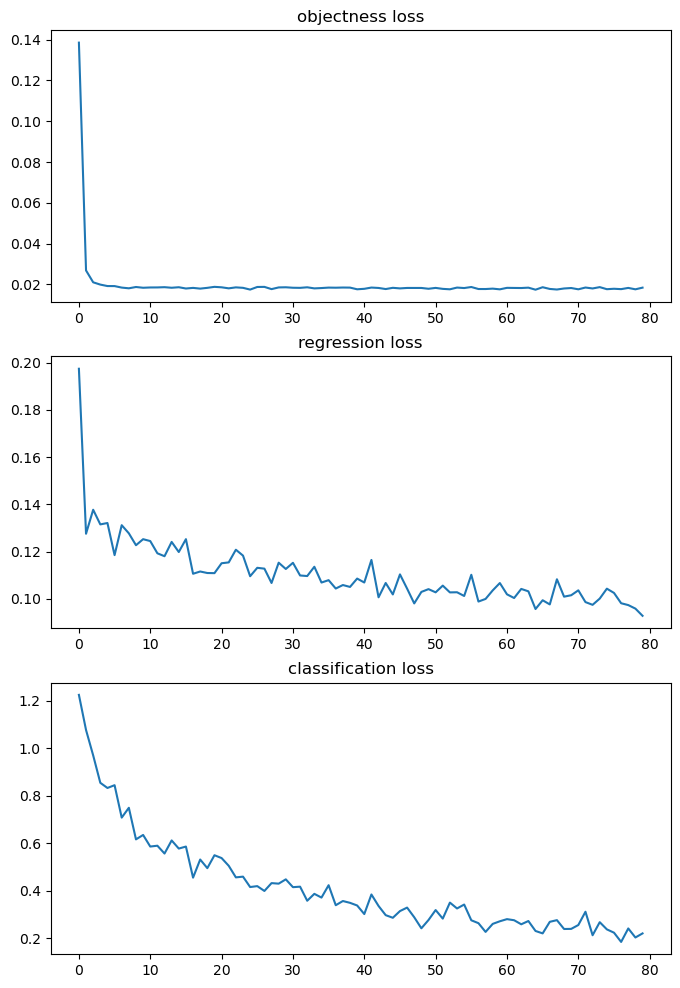

In [15]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(8, 12))
t = [
    "objectness loss",
    "regression loss",
    "classification loss",
]
for i in range(3):
    ax = axs[i]
    ax.plot(loss_record[:,i])
    ax.title.set_text(t[i])
fig.savefig("3_loss.png")

class list:  	bus  cat  pizza
total predict:	 37   36   49
total correct:	 34   31   42
average IoU:	0.27  0.26  0.31
prediction precision: 0.877049


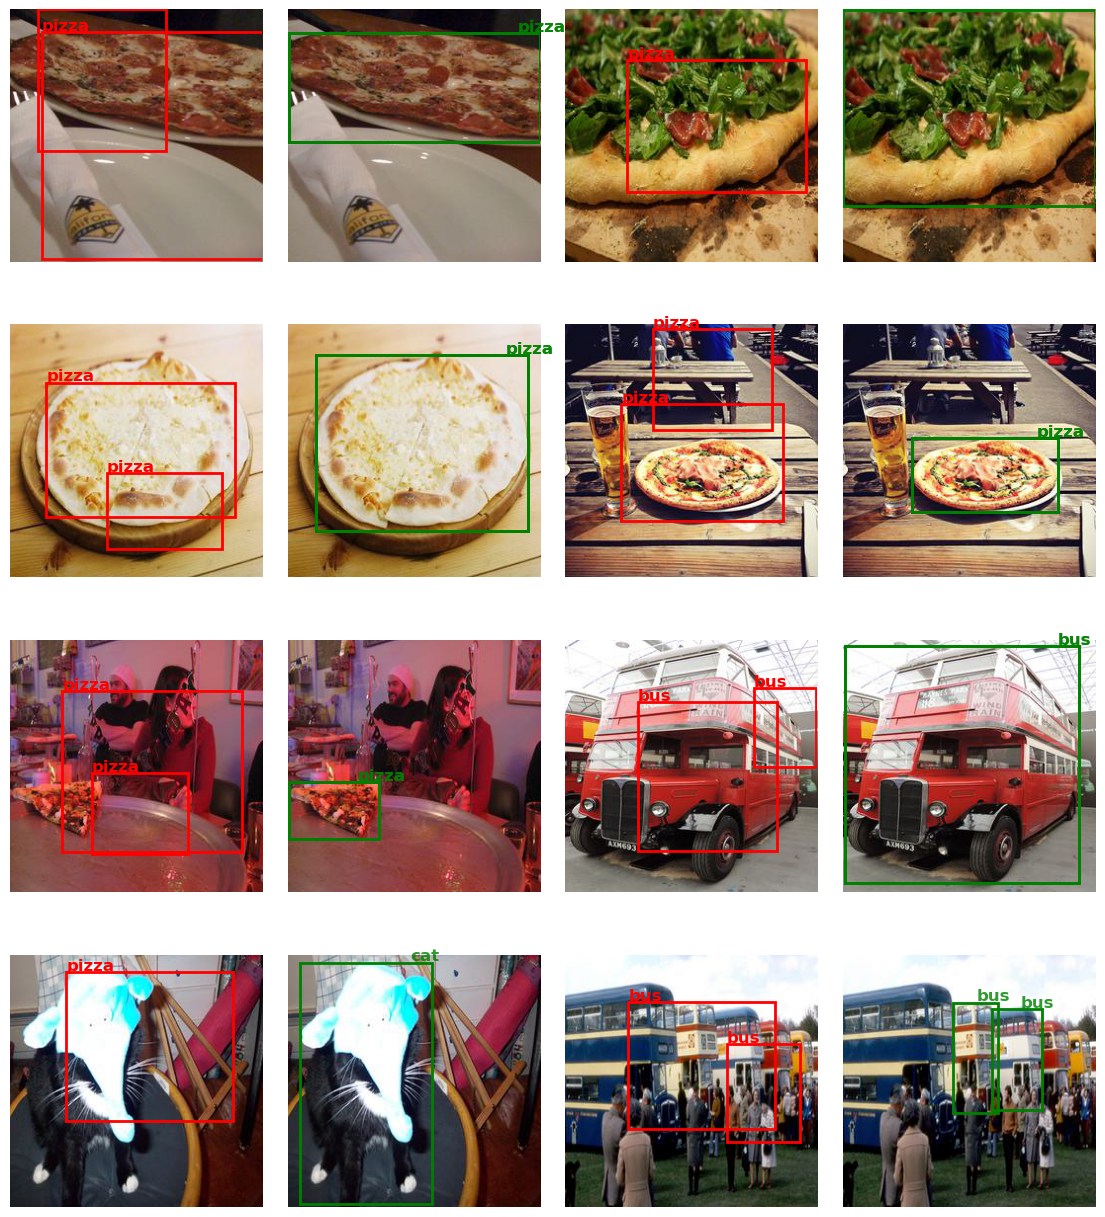

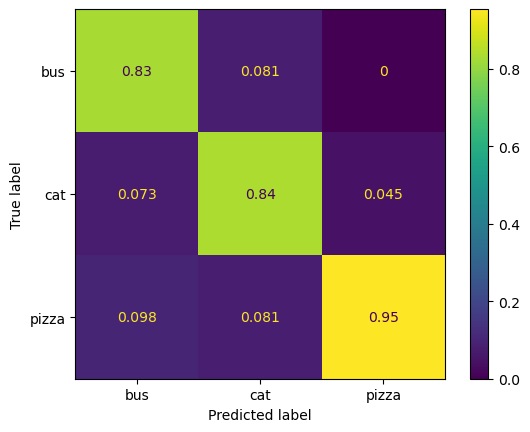

tensor([[34.,  3.,  0.],
        [ 3., 31.,  2.],
        [ 4.,  3., 42.]])

<Figure size 640x480 with 0 Axes>

In [39]:
gc.collect()
test_yolo(net, plot_image=True)

In [21]:
dataloader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)

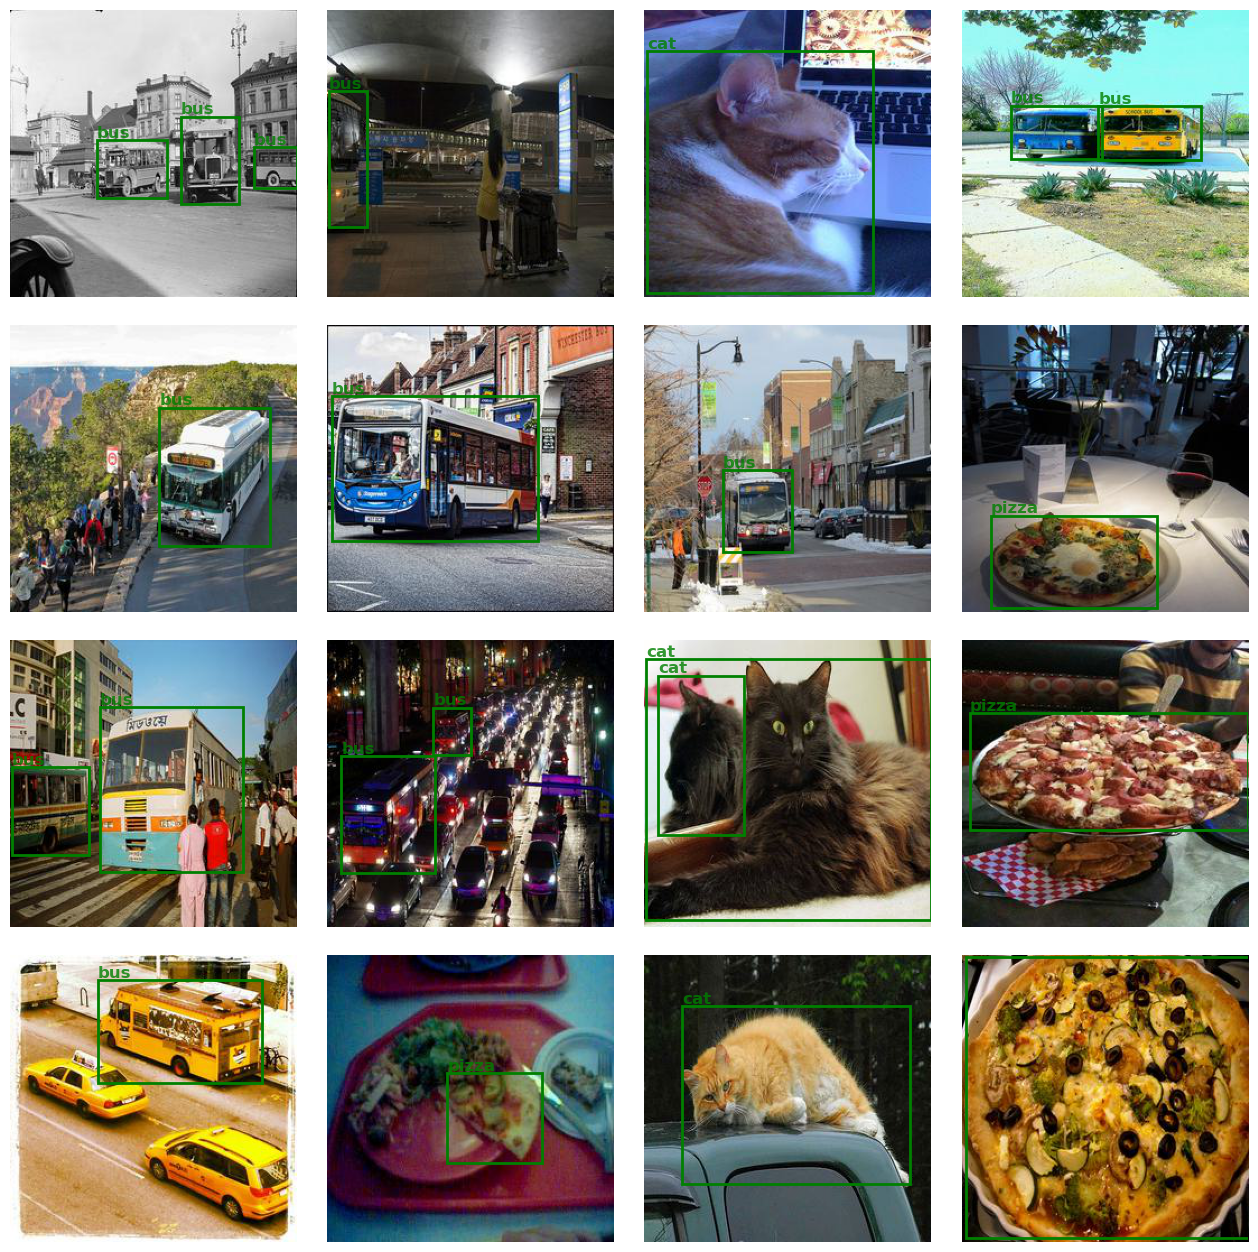

In [26]:
xform2 = tvt.Compose([
    # transform to range [-1, 1]:
    tvt.Normalize([-1,-1,-1], [2,2,2]),
    tvt.ToPILImage()
])


fig, axs = plt.subplots(nrows=4, ncols=4, squeeze=False, figsize=[16,16])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
axs = axs.flatten()

for iter, data in enumerate(dataloader):
    if iter >= 16: break
    img_tensor, labs_tensor, yolo_vectors, cell_ids, anchor_ids = data

    img = img_tensor[0]
    ground_bboxes = []
    for ic in range(cell_ids.shape[1]):
        if yolo_vectors[0,ic,0] == 0.0:
            ground_bboxes.append(None)
        else:
            ground_bboxes.append(
                recover_bbox_xywh( 
                    yolo_vectors[0,ic,1:5], 
                    cell_ids[0,ic],
                    anchor_ids[0,ic]
                )
            )

    ax = axs[iter]
    ax.imshow(xform2(img))

    for i in range(len(ground_bboxes)):
        if ground_bboxes[i] is None:
            continue
        b = (ground_bboxes[i]*256).tolist()
        cate = val_set.label_to_cat[labs_tensor[0,i].item()]
        ax.axis('off')
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2], b[3],fill=False, lw=2, edgecolor='g'))
        ax.annotate(cate, (b[0], b[1]-2), color='g', weight='bold', fontsize=12,alpha=0.8)
# ax1.add_patch(plt.Rectangle((b[0], b[1]), b[2], b[3],fill=False, lw=2, edgecolor='r'))
# ax1.annotate("car", (b[0], b[1]-2), color='r', weight='bold', fontsize=12,alpha=0.8)
# bbox = torch.tensor([0.3, 0.3, 0.6, 0.6], dtype=torch.float)
# b = (bbox*256).tolist()
# ax1.add_patch(plt.Rectangle((b[0], b[1]), b[2], b[3],fill=False, lw=2, edgecolor='g'))
# ax1.annotate("pizza", (b[0]+b[2]-22, b[1]-2), color='g', weight='bold', fontsize=12, )

plt.show()
fig.savefig('train.png')
# plt.imshow(fig)

In [ ]:
import torchviz

x = torch.zeros(1,3,256,256)
y = net(x)
torchviz.make_dot(y, params=dict(net.named_parameters()))